# CytoData 2018 - Hackathon
## Creating a submission entry 

In [12]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import cytodata



import os
from pathlib import Path
import skimage.external.tifffile as tiff

from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Load datasets
**Datasets available**: BBBC037 and BBBC043

**Data partitions**: Train and Test

**Features**: CellProfiler and DeepLearning

In [14]:
bbbc037_train = cytodata.load_dataset("BBBC037", partition="Train", features="CellProfiler")
bbbc043_train = cytodata.load_dataset("BBBC043", partition="Train", features="CellProfiler")

1it [00:07,  7.79s/it]
1it [00:25, 25.74s/it]


In [5]:
import cytodata
import torch
from torch.utils.data import Dataset, DataLoader


class CytodataDataset(Dataset):
    def __init__(self):
        self.bbbc037_train = cytodata.load_dataset("BBBC037", partition="Train", features="CellProfiler")
        self.bbbc043_train = cytodata.load_dataset("BBBC043", partition="Train", features="CellProfiler")

        print("Shape of datasets:", self.bbbc037_train.shape, self.bbbc043_train.shape)

        # create mapping of treatments
        bbbc043_tr = set(self.bbbc043_train.Metadata_x_mutation_status.unique())
        bbbc037_tr = set(self.bbbc037_train.Metadata_gene_name.unique())

        bbbc043_wt = []
        for treatment in bbbc043_tr:
            splitted = treatment.split("_")
            if len(splitted) == 1 or splitted[1].find("WT") > -1:
                bbbc043_wt.append(splitted[0])

        self.common_tr = set(bbbc043_wt).intersection(bbbc037_tr)

        self.features_037 = set([f for f in self.bbbc037_train.columns if not f.startswith("Metadata")])
        self.features_043 = set([f for f in self.bbbc043_train.columns if not f.startswith("Metadata")])

    def __len__(self):
        return self.bbbc037_train.shape[0] * self.bbbc043_train.shape[0]

    def __getitem__(self, idx):
        idx037 = idx % self.bbbc037_train.shape[0]
        idx043 = idx // self.bbbc037_train.shape[0]
        feature1 = self.bbbc037_train.ix[idx037][self.features_037].values
        feature2 = self.bbbc043_train.ix[idx043][self.features_043].values
        label = -1
        treatment037 = self.bbbc037_train.ix[idx037]["Metadata_gene_name"]
        treatment043 = self.bbbc043_train.ix[idx043]["Metadata_x_mutation_status"].split("_")
        if treatment037 == treatment043[0] and ( len(treatment043) == 1 or treatment043[1].find("WT") > -1 ) :
            label = 1
        return (feature1.astype(np.float32), feature2.astype(np.float32), label)

In [ ]:
# dataloader = DataLoader(CytodataDataset(), batch_size = 256, shuffle = True)
trainiter = iter(dataloader)
f1,f2, label = trainiter.next()
print (f1)
print (f2)
print (label)

In [ ]:
# Branch 1
class NeuralNet(nn.Module):
    def __init__(self, input_size_x, hidden_size_x, input_size_y, hidden_size_y, last_n):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size_x, hidden_size_x) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_x, last_n)  
        
        self.fc1 = nn.Linear(input_size_y, hidden_size_y) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_y, last_n)
    
    def forward(self, x, y):
        out_37 = self.fc1(x)
        out_37 = self.relu(out_37)
        out_37 = self.fc2(out_37)
        
        out_43 = self.fc1(y)
        out_43 = self.relu(out_43)
        out_43 = self.fc2(out_43)
        return out37, out43

In [ ]:
class NeuralCombine(NeuralNet):
        def __init__(self, out37, out_43):
        super(NeuralCombine, self).__init__()
        self.crosscorr = np.corrcoef(x=out37, y=out_43)
        
    

In [ ]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [ ]:
corr_matrix = np.corrcoef(x=aggregated_037[common_features], y=aggregated_043[common_features])
corr_matrix = corr_matrix[0:aggregated_037.shape[0], aggregated_037.shape[0]:]

In [15]:
print("Shape of datasets:", bbbc037_train.shape, bbbc043_train.shape)

Shape of datasets: (1800, 1801) (6048, 1803)


In [16]:
# Find common feature set

features_037 = set([f for f in bbbc037_train.columns if not f.startswith("Metadata")])
features_043 = set([f for f in bbbc043_train.columns if not f.startswith("Metadata")])

common_features = list(features_037.intersection(features_043))
print("Number of common features:", len(common_features))

Number of common features: 1783


In [17]:
bbbc043_tr = set(bbbc043_train.Metadata_x_mutation_status.unique())
bbbc037_tr = set(bbbc037_train.Metadata_gene_name.unique())
bbbc043_wt = []

for treatment in bbbc043_tr:
    splitted = treatment.split("_")
    if len(splitted) == 1 or splitted[1].find("WT") > -1:
       bbbc043_wt.append(splitted[0])
common_tr = set(bbbc043_wt).intersection(bbbc037_tr)

In [ ]:
common_tr

# 2. Build a model for processing data

In this example, we compute normalization parameters using control wells in the training set.

In [18]:
class NormalizeUsingJointControls(object):
    
    # Initialization function
    
    def __init__(self, dfA, dfB, common_features):
        self.dfA = dfA
        self.dfB = dfB
        self.common_features = common_features
        
    # Learning procedure
    
    def fit(self, control_column_A, control_column_B, control_value):
        # Collect control wells from both datasets
        
        controls_A = self.dfA[self.dfA[control_column_A] == control_value][self.common_features]
        controls_B = self.dfB[self.dfB[control_column_B] == control_value][self.common_features]
        
        # Compute control statistics
        
        controls = pd.concat([controls_A, controls_B])
        self.mean_ctl = controls.mean()
        self.std_ctl = controls.std()

        # Remove features with no variance
        
        no_variance = self.std_ctl[self.std_ctl == 0].index
        self.common_features = [c for c in self.common_features if c not in no_variance]
        
    # Transformation procedure
    
    def transform(self, df):
        # Z-score features
        
        norm = df.copy()
        norm[self.common_features] = df[self.common_features] - self.mean_ctl[self.common_features]
        norm[self.common_features] = norm[self.common_features] / self.std_ctl[self.common_features]
        
        return norm


In [19]:
# Create and fit normalization model 

model = NormalizeUsingJointControls(bbbc037_train, bbbc043_train, common_features)
model.fit(
    control_column_A="Metadata_gene_name", 
    control_column_B="Metadata_x_mutation_status", 
    control_value="EMPTY"
)

# Apply normalization model to training data

normalized_037 = model.transform(bbbc037_train)
normalized_043 = model.transform(bbbc043_train)

# 3. Load test sets and apply learned model

The test data is not used for training, but needs to be transformed using the same model.

In [20]:
# Load test data

bbbc037_test = cytodata.load_dataset("BBBC037", "Test", "CellProfiler")
bbbc043_test = cytodata.load_dataset("BBBC043", "Test", "CellProfiler")

print("Test wells: BBBC037={}, BBBC043={}".format(bbbc037_test.shape[0], bbbc043_test.shape[0]))

1it [00:00,  1.42it/s]
1it [00:00,  1.54it/s]


Test wells: BBBC037=115, BBBC043=96


In [21]:
# Apply normalization model

normalized_037_test = model.transform(bbbc037_test)
normalized_043_test = model.transform(bbbc043_test)

In [22]:
# Merge training and test sets

normalized_037 = pd.concat([normalized_037, normalized_037_test])
normalized_043 = pd.concat([normalized_043, normalized_043_test])

# 4. Aggregate profiles
All the processes above work at with well-level data, also known as replicate-level data. Now we need to aggregate and transform well-level data into treatment-level profiles. In this example, we use the mean profiling technique.

In [23]:
# Compute mean profile of treatments (accross replicates)

aggregated_037 = normalized_037.groupby(["Metadata_gene_name"])[common_features].mean()
aggregated_043 = normalized_043.groupby(["Metadata_x_mutation_status"])[common_features].mean()

In [24]:
data_37=aggregated_037[common_features]
data_43=aggregated_043[common_features]
print(data_37.shape, data_43.shape)

(194, 1783) (594, 1783)


In [25]:
print("Shape of treatment-level data", aggregated_037.shape, aggregated_043.shape)

Shape of treatment-level data (194, 1783) (594, 1783)


# 5. Compute connectivity matrix
With treatment-level profiles, proceed to match treatments from one database to the other. In this example we match treatments using Pearson Correlation similarity function.

**Important**: the values of the connectivity matrix are assumed to be similarity values (higher scores mean higher connectivity) as opposed to distance values (higher scores mean longer distances and low connectivity).

In [26]:
# Similarity matrix using Pearson Correlation

corr_matrix = np.corrcoef(x=aggregated_037[common_features], y=aggregated_043[common_features])
corr_matrix = corr_matrix[0:aggregated_037.shape[0], aggregated_037.shape[0]:]

In [27]:
corr_matrix

array([[-0.75459, -0.74587, -0.73499, ..., -0.08671, -0.70908, -0.02887],
       [-0.72495, -0.71193, -0.75326, ..., -0.12618, -0.71124, -0.05106],
       [-0.61503, -0.6677 , -0.66684, ...,  0.14146, -0.67   ,  0.21242],
       ...,
       [-0.61693, -0.69264, -0.6251 , ..., -0.02965, -0.6005 ,  0.01634],
       [-0.68616, -0.74313, -0.77573, ..., -0.01782, -0.73614,  0.05818],
       [-0.63467, -0.65232, -0.55422, ..., -0.06497, -0.59719, -0.04999]])

In [28]:
# Statistics of the connectivity matrix

print("Connectivity matrix shape:", corr_matrix.shape)
print("Max: {}, Min: {}, Mean: {}, Median: {}".format(np.max(corr_matrix), np.min(corr_matrix), np.mean(corr_matrix), np.median(corr_matrix)))

Connectivity matrix shape: (194, 594)
Max: 0.6536829747980729, Min: -0.8721749930388344, Mean: -0.3191713156616989, Median: -0.26239301825107686


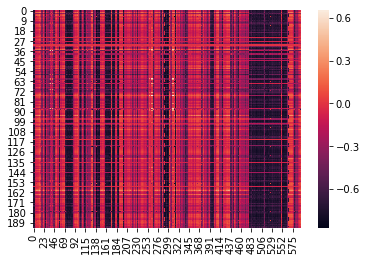

In [29]:
# Visualization of the connectivity matrix

sb.heatmap(corr_matrix)

# 6. Create submission file

Finally, save the connectivity matrix using treatment-level profiles, with columns and rows labeled with the ID of treatments. 

In [17]:
submission = pd.DataFrame(
    data=corr_matrix, 
    index=aggregated_037.index, 
    columns=aggregated_043.index)

submission = submission.reset_index()

In [18]:
SUBMISSION_NAME = "cytodata-baseline"
submission.to_csv(SUBMISSION_NAME + ".csv", index=False)